# Project II: Classifying Handwritten Digits From MNIST Data Set.

## Group 3 Project Members:

- Migabo Kisimbanyi Evariste
- Lilly Kandagor Aengwo
- Nnaa-Piam Alhassan
- Janvier KWIZERA

## $\bullet$ Objective

We want to apply the knowledge of Topological Data Analysis, concepts like Persistent Homology in classifying data which are a crucial aspect of our today, and needs to be studied in order to discover patterns and derive insights hencewith.

## $\bullet$ Loading Necessary Libraries and Modules

In [190]:
import pickle
import numpy as np
import joblib
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

## $\bullet$ Load the MNIST dataset and View a sample of digit "9"

In [161]:
n_samples = 1000 # number of loaded MNIST handwritten digits

n_features = 32 # number of features per image
image_size = 28 # MNIST handwritten digits images are 28x28
data_X = np.load('G:\\MK EVARISTE\\Downloads\\X_' + str(n_samples) + '.npy', allow_pickle=True)
data_y = np.load('G:\\MK EVARISTE\\Downloads\\y_'  + str(n_samples) + '.npy', allow_pickle=True)

In [162]:
np.flatnonzero(data_y == "9")[0]

4

In [163]:
import numpy as np
from gtda.plotting import plot_heatmap

im8_idx = np.flatnonzero(data_y == "9")[0]
img8 = data_X[im8_idx].reshape(28, 28)
plot_heatmap(img8)

## $\bullet$ Splitting the Data set into training and test sets

In [164]:
from sklearn.model_selection import train_test_split

train_size, test_size = 250, 60

# Reshape to (n_samples, n_pixels_x, n_pixels_y)
y = data_y
X = data_X.reshape((-1, 28, 28))

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=60, train_size=250, random_state=42)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (250, 28, 28), y_train shape: (250,)
X_test shape: (60, 28, 28), y_test shape: (60,)


## $\bullet$ Binarizing a Sample of the Data Sample

In [167]:
from gtda.images import Binarizer

# Pick out index of first 8 image
im8_idx = np.flatnonzero(y == "9")[0]
# Reshape to (n_samples, n_pixels_x, n_pixels_y) format
im8 = X[im8_idx][None, :, :]
im8 = 1/255*im8
binarizer = Binarizer(threshold= 0.45)
im8_binarized = binarizer.fit_transform(im8)

binarizer.plot(im8_binarized)

## $\bullet$ Applying Radial Filtration to the Data Sample

In [168]:
from gtda.images import RadialFiltration

radial_filtration = RadialFiltration(center=np.array([0, 0]))
im8_filtration = radial_filtration.fit_transform(im8_binarized)

radial_filtration.plot(im8_filtration, colorscale="jet")

## $\bullet$ Viewing persistence diagram for our sample

Given a greyscale filtration it is straightforward to calculate the corresponding persistence diagram. In ``giotto-tda`` we make use of the ``CubicalPersistence`` transformer which is the cubical analogue to simplicial transformers like ``VietorisRipsPersistence``:

In [169]:
from gtda.homology import CubicalPersistence

cubical_persistence = CubicalPersistence(n_jobs=-1)
im8_cubical = cubical_persistence.fit_transform(im8_filtration)

cubical_persistence.plot(im8_cubical)

We can clearly see 1 persistent component for $H_1$ generators corresponding to the loop in the digit "9".

In [170]:
from gtda.diagrams import Scaler

scaler = Scaler()
im8_scaled = scaler.fit_transform(im8_cubical)

scaler.plot(im8_scaled)

## $\bullet$ Viewing heat map from the persistence diagram for our sample

In [171]:
from gtda.diagrams import HeatKernel

heat = HeatKernel(sigma=.15, n_bins=60, n_jobs=-1)
im8_heat = heat.fit_transform(im8_scaled)

# Visualise the heat kernel for H1
heat.plot(im8_heat, homology_dimension_idx=1, colorscale='jet')

In [172]:
im9_heat.shape

(1, 2, 60, 60)

In [156]:
from sklearn.pipeline import Pipeline
from gtda.diagrams import Amplitude

steps = [
    ("binarizer", Binarizer(threshold=0.4)),
    ("filtration", RadialFiltration(center=np.array([0, 0]))),
    ("diagram", CubicalPersistence()),
    ("rescaling", Scaler()),
    ("amplitude", Amplitude(metric="heat", metric_params={'sigma':0.15, 'n_bins':60}))
]

heat_pipeline = Pipeline(steps)

In [173]:
im8_pipeline = heat_pipeline.fit_transform(im8)
im8_pipeline

array([[0.48062888, 1.49944247]])

## $\bullet$ Building a full-blown feature extraction pipeline 


In [194]:
from sklearn.pipeline import make_pipeline, make_union
from gtda.diagrams import PersistenceEntropy
from gtda.images import HeightFiltration

# Carefully selected directions for height filtrations
direction_list = [[1, 0],[-1, -1]]  # Two distinct directions

# Carefully selected centers for radial filtrations
center_list = [
    [6, 6],
    [20, 6],
    [14, 7],  # Three centers for radial filtrations
]

# Creating a list of all filtration transformers to be applied
filtration_list = (
    [
        HeightFiltration(direction=np.array(direction), n_jobs=-1)
        for direction in direction_list
    ]
    + [RadialFiltration(center=np.array(center), n_jobs=-1) for center in center_list]
)

# Creating the diagram generation pipeline
diagram_steps = [
    [
        Binarizer(threshold=0.4, n_jobs=-1),
        filtration,
        CubicalPersistence(n_jobs=-1),
        Scaler(n_jobs=-1),
    ]
    for filtration in filtration_list
]

# Updated metric list for selected features
metric_list = [
    {"metric": "bottleneck", "metric_params": {}},
    {"metric": "wasserstein", "metric_params": {"p": 2}},
    {"metric": "landscape", "metric_params": {"p": 1, "n_layers": 3, "n_bins": 100}},
    {"metric": "betti", "metric_params": {"p": 2, "n_bins": 100}},
    {"metric": "heat", "metric_params": {"p": 2, "sigma": 3.0, "n_bins": 100}},
]

# Feature extraction pipeline
feature_union = make_union(
    *[PersistenceEntropy(nan_fill_value=-1)]
    + [Amplitude(**metric, n_jobs=-1) for metric in metric_list]
)

tda_union = make_union(
    *[make_pipeline(*diagram_step, feature_union) for diagram_step in diagram_steps],
    n_jobs=-1
)

which can be visualised using ``scikit-learn``'s nifty [HTML feature](https://scikit-learn.org/stable/modules/compose.html#visualizing-composite-estimators):

# $\bullet$ Visualizing the feature diagram.

In [195]:
from sklearn import set_config
set_config(display='diagram')  

tda_union

FeatureUnion(n_jobs=-1,
             transformer_list=[('pipeline-1',
                                Pipeline(steps=[('binarizer',
                                                 Binarizer(n_jobs=-1,
                                                           threshold=0.4)),
                                                ('heightfiltration',
                                                 HeightFiltration(direction=array([1, 0]),
                                                                  n_jobs=-1)),
                                                ('cubicalpersistence',
                                                 CubicalPersistence(n_jobs=-1)),
                                                ('scaler', Scaler(n_jobs=-1)),
                                                ('featureunion',
                                                 FeatureUnion(transformer_list=[('persistenceentropy',
                                                                                 Persist...
                                                                                ('amplitude-2',
                                                                                 Amplitude(metric='wasserstein',
                                                                                           metric_params={'p': 2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-3',
                                                                                 Amplitude(metric_params={'n_bins': 100,
                                                                                                          'n_layers': 3,
                                                                                                          'p': 1},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-4',
                                                                                 Amplitude(metric='betti',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2},
                                                                                           n_jobs=-1)),
                                                                                ('amplitude-5',
                                                                                 Amplitude(metric='heat',
                                                                                           metric_params={'n_bins': 100,
                                                                                                          'p': 2,
                                                                                                          'sigma': 3.0},
                                                                                           n_jobs=-1))]))]))])

# $\bullet$ Displaying the size of the image feature.

In [196]:
X_train_tda = tda_union.fit_transform(X_train)
X_train_tda.shape

(250, 60)

As we can observe in the above output, the length of vectorized feature container is 60.

## $\bullet$ Save the Features to a .pkl File

In [197]:
joblib.dump(X_train_tda, 'transformed_features.pkl')
print("Transformed features were successfully saved to 'transformed_features.pkl'.")

Transformed features were successfully saved to 'transformed_features.pkl'.


## $\bullet$ Building a simple Random Forest Classifier

Let us train a Random Forest classifier on our training set to see what kind of performance we can get:

In [198]:
from sklearn.ensemble import RandomForestClassifier
# Ensure feature vector length <= 200
if X_train_tda.shape[1] > 200:
    X_train_tda = X_train_tda[:, :200]

# Step 3: Train Classifier (Using Random Forest)
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

# Step 4: Test Classifier
# Apply TDA pipeline to test data
X_test_tda = tda_union.transform(X_test)

# Ensure feature vector length <= 200
if X_test_tda.shape[1] > 200:
    X_test_tda = X_test_tda[:, :200]

# Check if X_test_tda and test_y have consistent lengths
if X_test_tda.shape[0] != len(y_test):
    raise ValueError(f"Inconsistent number of samples: X_test_tda has {X_test_tda.shape[0]} samples, but test_y has {len(y_test)}.")

# Evaluate the Random Forest classifier on test data
accuracy = rf.score(X_test_tda, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


Test Accuracy: 86.67%


## $\bullet$ Building a Simple Deep Neural Network Classifier 

In [199]:
from sklearn.neural_network import MLPClassifier
# Use MLPClassifier (Deep Neural Network) instead of RandomForestClassifier
mlp = MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=0)  # Example settings

# Train the model on the transformed training data
mlp.fit(X_train_tda, y_train)

# Apply the pipeline to the test data and evaluate the model
X_test_tda = tda_union.transform(X_test)
print("Test set accuracy: {:.2f}".format(mlp.score(X_test_tda, y_test)))

g:\Anaconda\Lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:691: ConvergenceWarning:

Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.



Test set accuracy: 0.82


## $\bullet$ Visualizing the Confusion Matrix of the random forest classifier

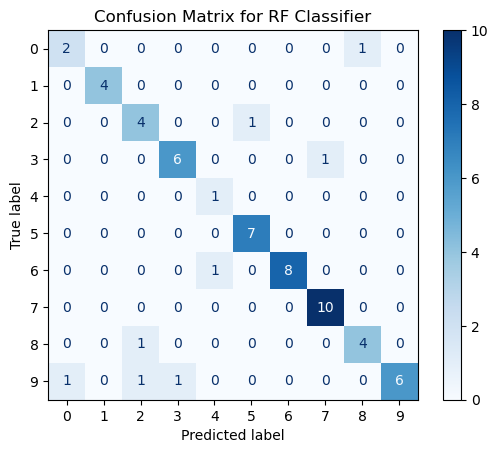

In [200]:
# Fit the random forest model
rf = RandomForestClassifier()
rf.fit(X_train_tda, y_train)

# Transform the test data using the TDA pipeline
X_test_tda = tda_union.transform(X_test)

# Predict on the transformed test data
y_pred = rf.predict(X_test_tda)

# Calculate confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf.classes_)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for RF Classifier")
plt.show()